# Realistic alternatives: Substituting the worst train connections with electrified highways.

## 1. Introduction
<!-- Introduces the problem and motivates your work --> 

Travel time is one of the most important factors in the decision for a mode of transportation.
This project aims to give insights into the extent of the advantage of travel by car over travel by train. 
Routes which are significantly faster by car are analysed with respect to their degree of electrification.
A suggestion for improvements to the charging infrastructure will be made. 
Infrastructure projects such as new railways take up years in planning and executing.
With the spirit of "free passage for free citizens" ("Freie Fahrt für freie Bürger"), a reasonable and at the same time 
environmentally friendly alternative is presented: choosing the fast and flexible travel by car, but opting for EVs instead of fossil fuels.

#### Main Question
Which routes between German cities are the fastest by car (in comparison to travel by train) and should be electrified 
for a "quick win" (compared to new train tracks) in climate action?

## 2. Methods
<!-- Describes which data sources you used and why, how you built your data pipeline and which data cleaning / transformation steps you followed as well as any problems encountered during data engineering -->
#### 2.1 Data Sources

#### 2.2 Data Pipeline

#### 2.3 Challenges

problems: the "landkreise" were ambiguously named: some contain "kreis" and some don't.
some metrics were just too expensive to calculate (ex. coverage %).

## 3. Results

### EV Chargers in Germany

In [1]:
%cd ..
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

/Users/lisaschmidt/Documents/GitHub/data-engineering-showcase


In [2]:
cnx = sqlite3.connect('data/charging_points_development.sqlite')
df_development = pd.read_sql_query("SELECT * FROM districts", cnx)

,chargers
state,
Bayern,17535
Nordrhein-Westfalen,15776
Baden-Württemberg,15531
Niedersachsen,8479
Hessen,6604
Schleswig-Holstein,3500
Sachsen,3449
Rheinland-Pfalz,3266
Berlin,2414


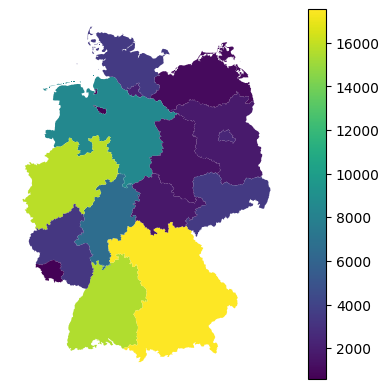

In [3]:
df_chargers_states = df_development[["state", "2023"]]
df_chargers_states = df_chargers_states.rename(columns={"2023":"chargers"})
df_chargers_states = df_chargers_states.groupby("state")["chargers"].sum()

import geopandas as gpd
df_states = gpd.read_file('./GER_shape/DEU_adm1.shp')
df_states = df_states.set_index('NAME_1')
df_states["chargers-2023"] = df_chargers_states

df_states.plot(column="chargers-2023", kind="geo", legend=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

pd.DataFrame(df_chargers_states).sort_values(by="chargers", ascending=False)

### Development of EV charging stations overall in Germany

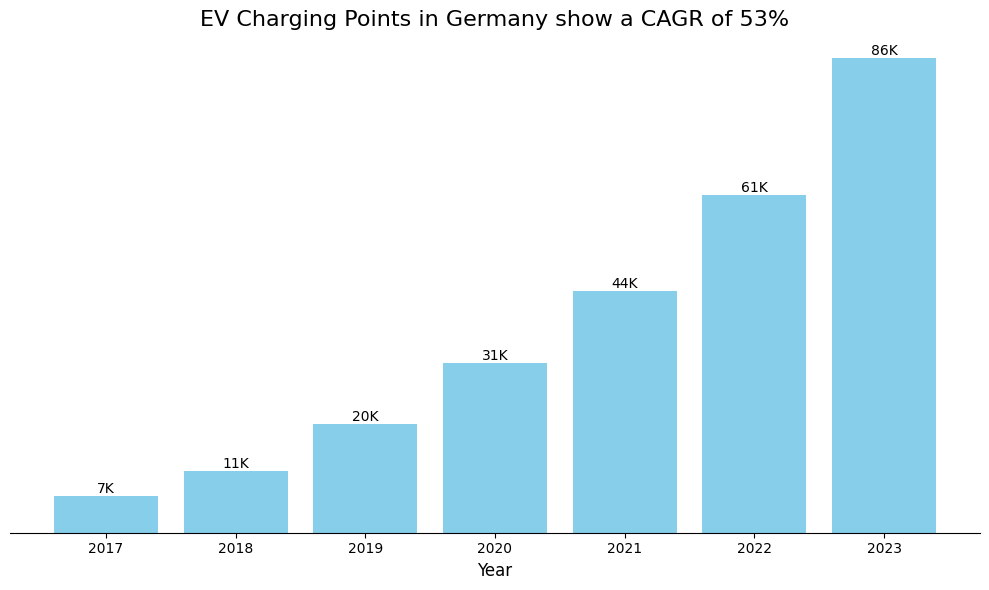

In [4]:
years = [str(d) for d in range(2017,2024)]
values = df_development.sum(axis=0)[2:]

plt.figure(figsize=(10, 6))
bars = plt.bar(years, values, color='skyblue')  # Use a professional color

plt.title('EV Charging Points in Germany show a CAGR of 53%', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Points', fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().yaxis.set_visible(False)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, str(int(round(yval/1000, 0)))+"K", 
             verticalalignment='bottom', horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

### Development of charging stations per district

In [5]:
cagr = ((df_development["2023"] / df_development["2020"]) ** (1 / 3) - 1) * 100
df_development["CAGR-3"] = cagr
df_development.sort_values(by="CAGR-3")[["location", "state", "CAGR-3"]][:5]

,location,state,CAGR-3
123,Regen,Bayern,-5.940289
132,Straubing-Bogen,Bayern,6.917811
211,Friesland,Niedersachsen,9.204330
160,Bremerhaven,Bremen,10.064242
158,Uckermark,Brandenburg,11.804676


In [6]:
df_development.sort_values(by="CAGR-3")[["location", "state", "CAGR-3"]][-5:]

,location,state,CAGR-3
42,Stuttgart,Baden-Württemberg,131.090655
171,Groß-Gerau,Hessen,132.587532
313,Cochem-Zell,Rheinland-Pfalz,149.331548
155,Prignitz,Brandenburg,151.984210
189,Schwerin,Mecklenburg-Vorpommern,233.222185


NAME_1
Saarland                  70.064454
Mecklenburg-Vorpommern    69.500122
Brandenburg               54.972203
Baden-Württemberg         46.882587
Hessen                    45.541177
Sachsen                   44.116820
Rheinland-Pfalz           42.932372
Bayern                    42.505295
Nordrhein-Westfalen       41.795339
Niedersachsen             40.807948
Schleswig-Holstein        38.877050
Sachsen-Anhalt            38.403632
Thüringen                 35.770980
Berlin                    33.482318
Hamburg                   22.102430
Bremen                    20.678124
Name: CAGR-3, dtype: float64

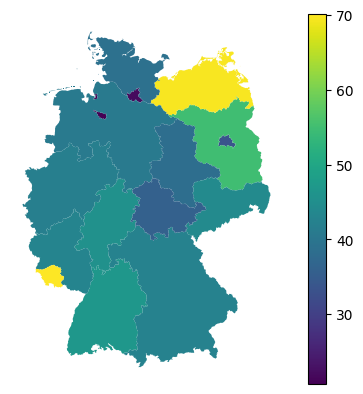

In [7]:
df_states["CAGR-3"] = df_development.groupby("state")["CAGR-3"].mean()

df_states.plot(column="CAGR-3", kind="geo", legend=True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.gca().xaxis.set_visible(False)

pd.DataFrame(df_states).sort_values(by="CAGR-3", ascending=False)["CAGR-3"]

### Worst routes for taking a train

In [8]:
from project.route_processing import aggregate_travel_modes, calculate_absolute_deviation, calculate_relative_deviation, compute_connectivity_metrics

In [9]:
cnx = sqlite3.connect('data/charging_points_germany.sqlite')
df_chargers = pd.read_sql_query("SELECT * FROM chargers", cnx)
df_chargers

,operator,city,state,district,latitude,longitude,rated_capacity
0,Albwerk GmbH & Co. KG,Heroldstatt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.442398,9.659075,22.0
1,smopi,Heroldstatt,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.449353,9.672201,22.0
2,Albwerk GmbH & Co. KG,Westerheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.510500,9.609000,22.0
3,EnBW mobility+ AG und Co.KG,Amstetten,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.578534,9.874840,98.0
4,SWU Energie GmbH,Balzheim,Baden-Württemberg,Landkreis Alb-Donau-Kreis,48.179959,10.076977,22.0
...,...,...,...,...,...,...,...
54218,TEAG Mobil GmbH,Obertrebra,Thüringen,Landkreis Weimarer Land,51.060798,11.565503,300.0
54219,EnBW mobility+ AG und Co.KG,Apolda,Thüringen,Landkreis Weimarer Land,51.028940,11.517130,300.0
54220,EnBW mobility+ AG und Co.KG,Apolda,Thüringen,Landkreis Weimarer Land,51.028940,11.517130,300.0
54221,TEAG Mobil GmbH,Großheringen,Thüringen,Landkreis Weimarer Land,51.107188,11.659489,30.0


In [10]:
cnx = sqlite3.connect('data/connections.sqlite')
df_connections = pd.read_sql_query("SELECT * FROM connections", cnx)
df_connections

,start,end,transport_type,route,duration,driving_distance
0,Bremerhaven,Marl,car,LINESTRING(8.586580000000001 53.55175000000000...,152,288.831379
1,Bremerhaven,Marl,train,None,320,NaN
2,Bremerhaven,Marl,train,None,385,NaN
3,Bremerhaven,Marl,train,None,322,NaN
4,Dortmund,Karlsruhe,car,"LINESTRING(7.46417 51.51505, 7.461770000000000...",200,355.366236
...,...,...,...,...,...,...
40510,Chemnitz,Osnabrück,train,None,320,NaN
40511,Halle (Saale),Bielefeld,car,LINESTRING(11.970030000000001 51.4824400000000...,180,344.566496
40512,Halle (Saale),Bielefeld,train,None,231,NaN
40513,Halle (Saale),Bielefeld,train,None,192,NaN


In [11]:
df_connectivity = aggregate_travel_modes(df_connections)
df_connectivity['absolute_deviation'] = df_connectivity.apply(calculate_absolute_deviation, axis=1)
df_connectivity['relative_deviation'] = df_connectivity.apply(calculate_relative_deviation, axis=1)
df_connectivity

,start,end,transport_type,route,duration_car,driving_distance,duration_train,absolute_deviation,relative_deviation
0,Aachen,Augsburg,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",318,591.985462,302,-16,-5.031447
1,Aachen,Berlin,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",352,635.000556,351,-1,-0.284091
2,Aachen,Bielefeld,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",139,256.710612,193,54,38.848921
3,Aachen,Bochum,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",86,148.859200,130,44,51.162791
4,Aachen,Bonn,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",53,91.573778,75,22,41.509434
...,...,...,...,...,...,...,...,...,...
9697,Zwickau,Witten,car,"LINESTRING(12.49548 50.71851, 12.4960200000000...",253,477.327736,396,143,56.521739
9698,Zwickau,Wolfsburg,car,"LINESTRING(12.49548 50.71851, 12.4960200000000...",165,293.094787,280,115,69.696970
9699,Zwickau,Worms,car,"LINESTRING(12.49548 50.71851, 12.4960200000000...",237,435.957279,362,125,52.742616
9700,Zwickau,Wuppertal,car,"LINESTRING(12.49548 50.71851, 12.4960200000000...",259,493.250391,394,135,52.123552


In [12]:
df_connectivity = pd.DataFrame(df_connectivity.iloc[:50])

In [13]:
densities, distances = compute_connectivity_metrics(df_chargers, df_connectivity)

100%|██████████| 50/50 [00:05<00:00,  8.84it/s]


In [14]:
df_connectivity['charger_density'] = densities
df_connectivity['avg_dist_charger'] = distances
df_connectivity[:5]

,start,end,transport_type,route,duration_car,driving_distance,duration_train,absolute_deviation,relative_deviation,geometry,charger_density,avg_dist_charger
0,Aachen,Augsburg,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",318,591.985462,302,-16,-5.031447,"LINESTRING (6.08492 50.77628000000001, 6.08666...",0.006888,1234.911463
1,Aachen,Berlin,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",352,635.000556,351,-1,-0.284091,"LINESTRING (6.08492 50.77628000000001, 6.08666...",0.005588,995.491315
2,Aachen,Bielefeld,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",139,256.710612,193,54,38.848921,"LINESTRING (6.08492 50.77628000000001, 6.08666...",0.006037,923.578395
3,Aachen,Bochum,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",86,148.859200,130,44,51.162791,"LINESTRING (6.08492 50.77628000000001, 6.08666...",0.008737,903.049892
4,Aachen,Bonn,car,"LINESTRING(6.08492 50.77628000000001, 6.08666 ...",53,91.573778,75,22,41.509434,"LINESTRING (6.08492 50.77628000000001, 6.08666...",0.009894,1110.329029


### Best routes for taking a train

### Are the worst routes electrified?
calculate the longest distance without a charger

## Discussion